# Recruitment Agency Resume Analysis Workflow using LangGraph

In [4]:
from dotenv import load_dotenv
load_dotenv()

True

## Try a sample chat to check the OPenAI Key with a chat

In [5]:
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate
llm = ChatOpenAI()
prompt = ChatPromptTemplate.from_template("tell me a joke about {foo}")
chain = prompt | llm
chain.invoke({"foo": "bears"})


AIMessage(content='Why do bears have hairy coats?\n\nFur protection!', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 12, 'prompt_tokens': 13, 'total_tokens': 25, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'id': 'chatcmpl-BNgWmAPOt7yC4gx7YQOmM6MSTmK1P', 'finish_reason': 'stop', 'logprobs': None}, id='run-4cb1fe0f-74f3-4b3b-93ca-dae539600d42-0', usage_metadata={'input_tokens': 13, 'output_tokens': 12, 'total_tokens': 25, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})

## Components of Langgraph
- State
- Nodes
- Edges

In [26]:
from typing_extensions import TypedDict
class State(TypedDict):
    job_description: str
    application: str
    experience_level: str
    skill_match: str
    response: str

In [62]:
from langgraph.graph import StateGraph, START, END
workflow = StateGraph(State)

In [63]:
def categorize_experience(state:State) -> State:
    print("\n Categorizing the experience level of candidate:")
    prompt = ChatPromptTemplate.from_template(
        """
        You are an experienced recruiter. 
        You are helping a candidate to improve their job search.
        You are given the candidate's application.
        You are asked to categorize the candidate's as 'Entry-level','Mid-level','Expert-level'.
        Application:{application}
    """)
    chain = prompt | llm
    experience_level = chain.invoke({"application": state["application"]}).content
    print(f"Experience Level: {experience_level}")
    return {"experience_level": experience_level}


In [64]:
def assess_Skillset(state: State) -> State:
    print("Assessing Skillset")
    prompt = ChatPromptTemplate.from_template(
        """
        You are a helpful assistant. You are helping a human with their career coaching. 
        You are given the application of a human and a job description. 
        You are asked to assess the human's skillset based on the job description. 
        
        Application: {application}
        Job Description: {job_description}

        Your response should be either 'Match' or 'No Match'.
        """
    )
    chain = prompt | llm
    skill_match = chain.invoke(
        {
            "application": state["application"],
            "job_description": state["job_description"]
        }
    )
    print(f"Skill Match:{skill_match.content}")
    return {"skill_match": skill_match.content}   
   

In [65]:
def schedule_interview(state:State)-> State:
    print("\nSchedule_interview")
    return {"response":"Candidate has been shortlisted for an HR interview"}

In [66]:
def escalate_to_recruiter(state:State)->State:
    print("\nEscalating to recruiter")
    return {"response":"Candidate has senior-level experience but doesn't match job skills."}



In [67]:
def reject_application(state:State)->State:
    print("\n Sending reject email")
    return {"response":"Candidate doesn't meet JD and has been rejected."}

## Create the Nodes

In [68]:
workflow.add_node("categorize_experience", categorize_experience)
workflow.add_node("assess_skillset", assess_Skillset)
workflow.add_node("schedule_interview",schedule_interview)
workflow.add_node("escalate_to_recruiter",escalate_to_recruiter)
workflow.add_node("reject_application", reject_application)

In [69]:
def route_app(state:State) ->str:
    if(state["skill_match"] == "Match"):
        print("Executing Match Route")
        return "schedule_interview"
    
    elif(state["experience_level"]=="Senior-level"):
        print("Executing Senior-level Route")
        return "escalate_to_recruiter"
    
    else:
        print("Executing Default Route")
        return "reject_application"

### Create the Edges

In [70]:
# Normal edge
workflow.add_edge("categorize_experience","assess_skillset")

# conditional edge
workflow.add_conditional_edges("assess_skillset", route_app)

# start and end node

workflow.add_edge(START, "categorize_experience")

workflow.add_edge("escalate_to_recruiter", END)
workflow.add_edge("reject_application", END)
workflow.add_edge("schedule_interview",END)



### Compile the graph

In [71]:
app = workflow.compile()

### Visualize the graph

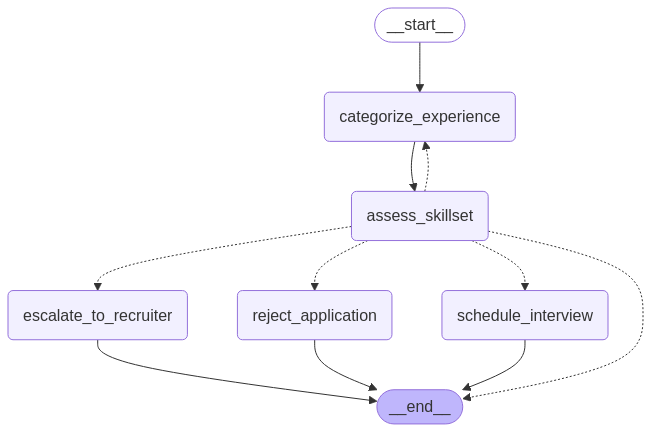

In [72]:
from IPython.display import Image, display
from langchain_core.runnables.graph import CurveStyle, MermaidDrawMethod, NodeStyles
display(Image(
    app.get_graph().draw_mermaid_png(
        draw_method = MermaidDrawMethod.API,
    )
)
)

## Access the Lang Graph we have and check the execution

In [73]:
def run_candidate_screening(application: str, job_description: str):
    results = app.invoke({"application":application, "job_description":job_description })
    return {
        "experience_level":results['experience_level'],
        "skill_match":results["skill_match"],
        "response":results["response"]
    }

In [74]:
application_text =" I have 20 years of C# .Net experience in developing Web application. Also I have experience in cloud services in Azure"
job_description = "I am looking for a candidate who has experience in developing Web application and cloud services in Azure"
results = run_candidate_screening(application_text, job_description)
print(f"Application: {application_text}")
print(f"Job Description: {job_description}")
print(f"Experience Level:{results["experience_level"]}")
print(f"Skill Match:{results["skill_match"]}")
print(f"Response:{results["response"]}")


 Categorizing the experience level of candidate:
Experience Level: Based on the information provided in the application, I would categorize this candidate as an 'Expert-level' candidate. With 20 years of experience in C# .Net development and experience in cloud services in Azure, the candidate has a wealth of knowledge and expertise that would qualify them for more advanced roles in the industry. I would recommend highlighting this expertise in their job search to attract opportunities that match their level of experience and skills.
Assessing Skillset
Skill Match:Match
Executing Match Route

Schedule_interview
Application:  I have 20 years of C# .Net experience in developing Web application. Also I have experience in cloud services in Azure
Job Description: I am looking for a candidate who has experience in developing Web application and cloud services in Azure
Experience Level:Based on the information provided in the application, I would categorize this candidate as an 'Expert-level

In [75]:
application_text =" I have 20 years of C# .Net experience in developing Web application. Also I have experience in cloud services in Azure"
job_description = "I am looking for a candidate who has 15 experience in developing Web application and cloud services using Python"
results = run_candidate_screening(application_text, job_description)
print(f"Application: {application_text}")
print(f"Job Description: {job_description}")
print(f"Experience Level:{results["experience_level"]}")
print(f"Skill Match:{results["skill_match"]}")
print(f"Response:{results["response"]}")


 Categorizing the experience level of candidate:
Experience Level: Based on the information provided in the candidate's application, I would categorize the candidate as an 'Expert-level' candidate. This is due to the candidate's extensive 20 years of experience in C# .Net development for Web applications, as well as their experience with cloud services in Azure. Candidates with this level of expertise are typically considered experts in their field and would likely be qualified for more senior or specialized roles in the industry.
Assessing Skillset
Skill Match:No Match
Executing Default Route

 Sending reject email
Application:  I have 20 years of C# .Net experience in developing Web application. Also I have experience in cloud services in Azure
Job Description: I am looking for a candidate who has 15 experience in developing Web application and cloud services using Python
Experience Level:Based on the information provided in the candidate's application, I would categorize the candid